In [30]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

In [31]:
plt.rcParams['figure.figsize'] = (10,5)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [33]:
# Lectura y preprocesado
files = {
    2022: "Alaska_so2_2022.csv",
    2023: "Alaska_so2_2023.csv",
    2024: "Alaska_so2_2024.csv"
}

dfs = []
for year, path in files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Archivo no encontrado: {path}")
    df = pd.read_csv(path)
    date_col = 'Date'
    value_col = 'Daily Max 1-hour SO2 Concentration'
    if date_col not in df.columns:
        raise KeyError(f"El archivo {path} no tiene la columna '{date_col}'.")
    if value_col not in df.columns:
        raise KeyError(f"El archivo {path} no tiene la columna '{value_col}'.")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])  # eliminar filas con fecha inválida
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    dfs.append(df[['Year','Month', value_col]])

# concatenar
df_total = pd.concat(dfs, ignore_index=True)

# calcular promedio mensual por año
df_monthly = df_total.groupby(['Year','Month'])['Daily Max 1-hour SO2 Concentration'].mean().unstack(level=1)

# asegurar columnas 1..12 (meses)
df_monthly = df_monthly.reindex(columns=range(1,13))

# renombrar columnas a nombres de mes
df_monthly.columns = month_names
df_pivot = df_monthly.reset_index()  # DataFrame con Year + Jan..Dec

# Mostrar
display(df_pivot)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2022,20.470968,14.67600,9.740385,5.670000,2.617742,2.343333,3.017742,1.677419,1.891525,2.508065,4.530000,5.737097
1,2023,5.321667,3.47500,4.335484,2.935000,2.217742,1.531667,1.787097,2.093443,1.873333,2.077966,2.380000,4.111290
2,2024,4.691935,5.24386,3.450000,2.576667,1.964516,2.773585,1.091228,0.822642,0.861667,1.746552,3.241667,4.553226


In [34]:
# Entrenamiento por mes
preds = {}
models = {}
fallback_info = {}

for m in month_names:
    # extraer valores por año (puede haber NaN)
    val_2022 = df_pivot.loc[df_pivot['Year'] == 2022, m].squeeze() if (df_pivot['Year'] == 2022).any() else np.nan
    val_2023 = df_pivot.loc[df_pivot['Year'] == 2023, m].squeeze() if (df_pivot['Year'] == 2023).any() else np.nan

    X = []
    y = []
    if not pd.isna(val_2022):
        X.append([2022]); y.append(float(val_2022))
    if not pd.isna(val_2023):
        X.append([2023]); y.append(float(val_2023))

    if len(y) >= 2:
        model = LinearRegression()
        model.fit(np.array(X), np.array(y))
        pred_2024 = model.predict(np.array([[2024]]))[0]
        models[m] = model
        fallback_info[m] = "regression (2 pts)"
    elif len(y) == 1:
        pred_2024 = y[-1]
        fallback_info[m] = "fallback: single value used"
    else:
        pred_2024 = np.nan
        fallback_info[m] = "no data"

    preds[m] = pred_2024

pred_df = pd.DataFrame([preds], index=[2024])[month_names]
print("Predicciones 2025 por mes:")
display(pred_df.T)
print("\nMétodo usado por mes:")
display(pd.Series(fallback_info))

Predicciones 2025 por mes:


,2024
Jan,-9.827634
Feb,-7.726000
Mar,-1.069417
Apr,0.200000
May,1.817742
Jun,0.720000
Jul,0.556452
Aug,2.509466
Sep,1.855141
Oct,1.647868



Método usado por mes:


,0
Jan,regression (2 pts)
Feb,regression (2 pts)
Mar,regression (2 pts)
Apr,regression (2 pts)
May,regression (2 pts)
Jun,regression (2 pts)
Jul,regression (2 pts)
Aug,regression (2 pts)
Sep,regression (2 pts)
Oct,regression (2 pts)


In [35]:
# Valores reales 2025
if (df_pivot['Year'] == 2024).any():
    real_2024 = df_pivot.loc[df_pivot['Year'] == 2024, month_names].iloc[0]
else:
    # Si no hay fila anual para 2025 (por ejemplo, no hay promedios), lo construimos desde los datos diarios:
    # Aunque nuestro paso 1 ya agrupa por año/mes, esto es una defensa adicional.
    real_2024 = df_monthly.loc[2024] if 2024 in df_monthly.index else pd.Series([np.nan]*12, index=month_names)

display(real_2024)


,2
Jan,4.691935
Feb,5.243860
Mar,3.450000
Apr,2.576667
May,1.964516
Jun,2.773585
Jul,1.091228
Aug,0.822642
Sep,0.861667
Oct,1.746552


In [39]:
# Comparar valores reales 2024 vs predicciones
valid_months = []
y_true = []
y_pred = []

for m in month_names:
    real_val = real_2024[m]
    pred_val = pred_df.loc[2024, m]
    if not pd.isna(real_val) and not pd.isna(pred_val):
        valid_months.append(m)
        y_true.append(real_val)
        y_pred.append(pred_val)

error_table = pd.DataFrame({
    "Month": valid_months,
    "Real": y_true,
    "Pred": y_pred,
    "AbsError": np.abs(np.array(y_true) - np.array(y_pred))
})

mae = error_table['AbsError'].mean()
rmse = np.sqrt((error_table['AbsError'] ** 2).mean())

display(error_table)
print("MAE:", mae)
print("RMSE:", rmse)


,Month,Real,Pred,AbsError
0,Jan,4.691935,-9.827634,14.519570
1,Feb,5.243860,-7.726000,12.969860
2,Mar,3.450000,-1.069417,4.519417
3,Apr,2.576667,0.200000,2.376667
4,May,1.964516,1.817742,0.146774
5,Jun,2.773585,0.720000,2.053585
6,Jul,1.091228,0.556452,0.534776
7,Aug,0.822642,2.509466,1.686824
8,Sep,0.861667,1.855141,0.993475
9,Oct,1.746552,1.647868,0.098684


MAE: 3.748253352926684
RMSE: 5.9639289453269075


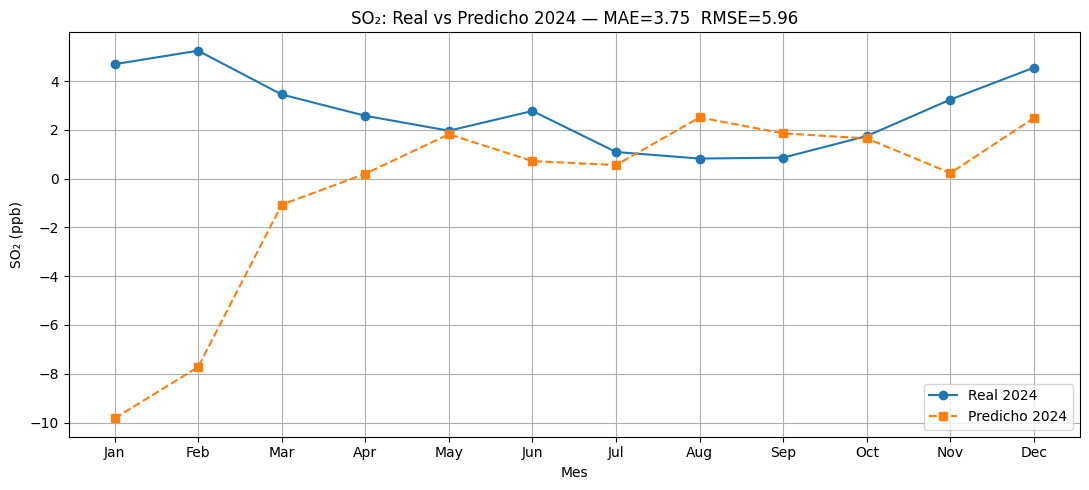

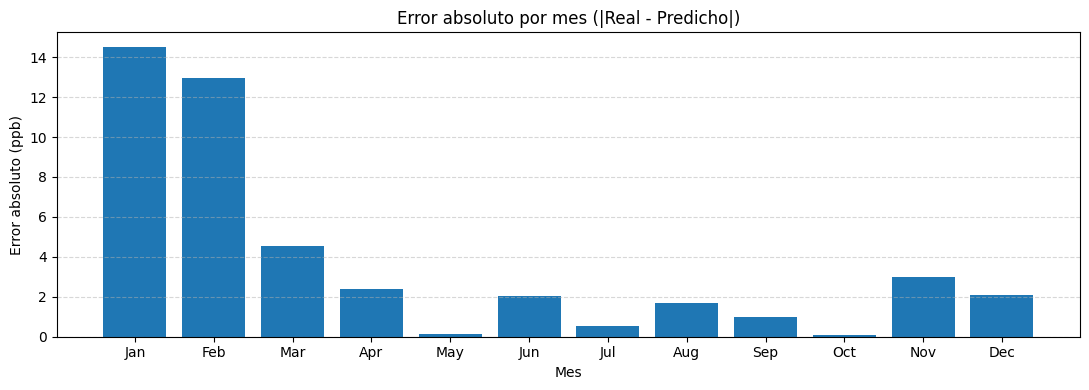

Resultados guardados en carpeta `results/`.


In [40]:
# Gráficos
if len(valid_months) > 0:
    # gráfico de líneas
    fig, ax = plt.subplots(figsize=(11,5))
    ax.plot(valid_months, y_true, marker='o', label='Real 2024')
    ax.plot(valid_months, y_pred, marker='s', linestyle='--', label='Predicho 2024')
    ax.set_xlabel('Mes')
    ax.set_ylabel('SO₂ (ppb)')  # ajusta la unidad según tus datos
    ax.set_title(f'SO₂: Real vs Predicho 2024 — MAE={mae:.2f}  RMSE={rmse:.2f}')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # barras de error absoluto
    fig2, ax2 = plt.subplots(figsize=(11,4))
    ax2.bar(valid_months, error_table['AbsError'])
    ax2.set_xlabel('Mes')
    ax2.set_ylabel('Error absoluto (ppb)')
    ax2.set_title('Error absoluto por mes (|Real - Predicho|)')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # guardar resultados en carpeta results/
    os.makedirs('results', exist_ok=True)
    pred_df.to_csv('results/predictions_2024.csv', index_label='Year')
    error_table.to_csv('results/error_by_month_2024.csv', index=False)
    fig.savefig('results/so2_real_vs_pred_2024.png')
    fig2.savefig('results/so2_error_by_month_2024.png')
    print("Resultados guardados en carpeta `results/`.")
else:
    print("No se generaron gráficos: no hay meses válidos para comparar.")
